# Hyperparameter Tuning for a Single Doc RAG

In [ ]:
!pip install llama_index==0.9.3 pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.7/886.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.6/277.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: beauti

## Load document

In [ ]:
import os, openai, logging, sys
import nest_asyncio

nest_asyncio.apply()

OPENAI_API_KEY = "sk-####################"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [ ]:
from llama_index import ServiceContext, SimpleDirectoryReader
from llama_index.llms import OpenAI
from llama_index.text_splitter import SentenceSplitter

documents = SimpleDirectoryReader("data").load_data()
print(f"loaded documents with {len(documents)} documents")

# Use the new flattened interface for node parsing
node_parser = SentenceSplitter(chunk_size=256)
nodes = node_parser(documents)
print(f"loaded {len(nodes)} nodes")

loaded documents with 8 documents
loaded 16 nodes


## Generate evaluation question/answer pairs

In [ ]:
from llama_index.evaluation import (
    DatasetGenerator,
    QueryResponseDataset,
)

eval_service_context = ServiceContext.from_defaults(llm=OpenAI(model="gpt-4-1106-preview"))

# load eval question/answer dataset from JSON file if exists
if os.path.exists("data/eval_qr_dataset.json"):
    eval_dataset = QueryResponseDataset.from_json("data/eval_qr_dataset.json")
else:
    # construct dataset_generator
    dataset_generator = DatasetGenerator(
        nodes[:8],
        service_context=eval_service_context,
        show_progress=True,
        num_questions_per_chunk=2,
    )

    # generate queries and responses
    eval_dataset = dataset_generator.generate_dataset_from_nodes()

    # save the dataset into a file
    eval_dataset.save_json("data/eval_qr_dataset.json")

100%|██████████| 2/2 [00:11<00:00,  5.87s/it]


In [ ]:
import json

# Load dataset from JSON file
with open("data/eval_qr_dataset.json", "r") as file:
    eval_dataset_content = json.load(file)

# Print the content in JSON format
json_str = json.dumps(eval_dataset_content, indent=2)  # indent for pretty printing
print(json_str)

{
  "queries": {
    "4aecbefc-e1a2-4413-a081-c2747fcddf42": "Explain the concept of \"DevOps self-service\" as described in the document \"DevOps_Self-Service_Pipeline_Architecture.pdf\" and discuss how it aims to transform the mindset of developers in terms of access, control, and ownership of pipelines.",
    "7288a643-f38f-451a-b32d-0fafee90d882": "According to the document, what is the significance of the 3\u20132\u20131 Rule in the context of DevOps Self-Service Pipeline Architecture, and how does it contribute to the productivity of developers?",
    "434b1927-6425-4dab-a736-3a71f58f5c44": "Explain the 3-2-1 rule as coined by the author in the context of the self-service pipeline architecture for microservices, and describe how it differs from the pipeline architecture for serverless workloads.",
    "ec1bd5c3-5b1f-4716-8565-b5293ca6ae51": "According to the document, how many types of source code are stored in the same GitHub repository for a microservice, and what is the signif

In [ ]:
eval_qs = eval_dataset.questions
ref_response_strs = [r for (_, r) in eval_dataset.qr_pairs]

['Explain the concept of "DevOps self-service" as described in the "DevOps Self-Service Pipeline Architecture" document. Discuss how it aims to change the mindset of developers and the benefits it provides in terms of access, control, and ownership.', 'According to the "DevOps Self-Service Pipeline Architecture" PDF, what is the significance of the 3–2–1 Rule in the context of self-service pipeline architecture? Provide a high-level overview of this rule based on the architectural insights presented in the document.', 'Explain the 3-2-1 rule as coined by the author in the context of the self-service pipeline architecture for microservices, and describe how it differs from the pipeline architecture for serverless workloads.', 'According to the document "DevOps_Self-Service_Pipeline_Architecture.pdf," what are the three types of source code that should reside in the same GitHub repository for a microservice?', 'Explain the significance of the shift from a centralized Terraform code repos

## Build index, query engine, gather parameters

In [ ]:
from llama_index import (
    VectorStoreIndex,
    load_index_from_storage,
    StorageContext,
    ServiceContext,
)
from llama_index.param_tuner.base import ParamTuner, TunedResult, RunResult
from llama_index.evaluation.eval_utils import get_responses
from llama_index.evaluation import SemanticSimilarityEvaluator, BatchEvalRunner

import os
import numpy as np
from pathlib import Path

def _build_index(chunk_size, docs):
    index_out_path = f"./storage_{chunk_size}"
    if not os.path.exists(index_out_path):
        Path(index_out_path).mkdir(parents=True, exist_ok=True)

        # Using the new flattened interface for node parsing
        node_parser = SentenceSplitter(chunk_size=chunk_size)
        nodes = node_parser(docs)

        # build index
        index = VectorStoreIndex(nodes)

        # save index to disk
        index.storage_context.persist(index_out_path)
    else:
        # rebuild storage context
        storage_context = StorageContext.from_defaults(
            persist_dir=index_out_path
        )
        # load index
        index = load_index_from_storage(
            storage_context,
        )
    return index

In [ ]:
# contains the parameters that need to be tuned
param_dict = {"chunk_size": [256, 512, 1024], "top_k": [1, 2, 5]}

# contains parameters remaining fixed across all runs of the tuning process
fixed_param_dict = {
    "docs": documents,
    "eval_qs": eval_qs,
    "ref_response_strs": ref_response_strs,
}

## Define EDD to measure the score for each parameter combination

In [ ]:
def _get_eval_batch_runner_semantic_similarity():
    eval_service_context = ServiceContext.from_defaults(
        llm=OpenAI(model="gpt-4-1106-preview")
    )
    evaluator_s = SemanticSimilarityEvaluator(
        service_context=eval_service_context
    )
    eval_batch_runner = BatchEvalRunner(
        {"semantic_similarity": evaluator_s}, workers=2, show_progress=True
    )

    return eval_batch_runner


def objective_function_semantic_similarity(params_dict):
    chunk_size = params_dict["chunk_size"]
    docs = params_dict["docs"]
    top_k = params_dict["top_k"]
    eval_qs = params_dict["eval_qs"]
    ref_response_strs = params_dict["ref_response_strs"]

    # build index
    index = _build_index(chunk_size, docs)

    # query engine
    query_engine = index.as_query_engine(similarity_top_k=top_k)

    # get predicted responses
    pred_response_objs = get_responses(
        eval_qs, query_engine, show_progress=True
    )

    # run evaluator
    eval_batch_runner = _get_eval_batch_runner_semantic_similarity()
    eval_results = eval_batch_runner.evaluate_responses(
        eval_qs, responses=pred_response_objs, reference=ref_response_strs
    )

    # get semantic similarity metric
    mean_score = np.array(
        [r.score for r in eval_results["semantic_similarity"]]
    ).mean()

    return RunResult(score=mean_score, params=params_dict)

## Run Parameter Turner

In [ ]:
from llama_index.param_tuner import ParamTuner

param_tuner = ParamTuner(
    param_fn=objective_function_semantic_similarity,
    param_dict=param_dict,
    fixed_param_dict=fixed_param_dict,
    show_progress=True,
)

results = param_tuner.tune()

best_result = results.best_run_result
best_top_k = results.best_run_result.params["top_k"]
best_chunk_size = results.best_run_result.params["chunk_size"]

print("")
print(f"Semantic Similarity Score: {best_result.score}")
print(f"Top-k: {best_top_k}")
print(f"Chunk size: {best_chunk_size}")

Param combinations.:   0%|          | 0/9 [00:00<?, ?it/s]



  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:01<00:26,  1.76s/it]

 19%|█▉        | 3/16 [00:02<00:08,  1.56it/s]

 38%|███▊      | 6/16 [00:02<00:03,  2.73it/s]

 44%|████▍     | 7/16 [00:02<00:02,  3.26it/s]

 50%|█████     | 8/16 [00:03<00:02,  3.76it/s]

 56%|█████▋    | 9/16 [00:03<00:01,  4.22it/s]

 62%|██████▎   | 10/16 [00:03<00:01,  3.49it/s]

 69%|██████▉   | 11/16 [00:04<00:02,  2.37it/s]

 75%|███████▌  | 12/16 [00:05<00:02,  1.86it/s]

 81%|████████▏ | 13/16 [00:05<00:01,  1.82it/s]

 94%|█████████▍| 15/16 [00:05<00:00,  2.99it/s]

100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:00<00:05,  2.84it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.92it/s]

 31%|███▏      | 5/16 [00:00<00:01,  5.97it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.80it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.11it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.19it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.50it/s]



Semantic Similarity Score: 0.9638983676470934
Top-k: 5
Chunk size: 1024


Score: 0.9638983676470934, Top_k: 5, Chunk_size: 1024
Score: 0.963885900528934, Top_k: 5, Chunk_size: 512
Score: 0.963487726884144, Top_k: 5, Chunk_size: 256
Score: 0.9612301684947645, Top_k: 2, Chunk_size: 1024
Score: 0.960599678303695, Top_k: 2, Chunk_size: 256
Score: 0.9573923091980221, Top_k: 2, Chunk_size: 512
Score: 0.954668662167844, Top_k: 1, Chunk_size: 256
Score: 0.9528468594254222, Top_k: 1, Chunk_size: 1024
Score: 0.9508591283172372, Top_k: 1, Chunk_size: 512


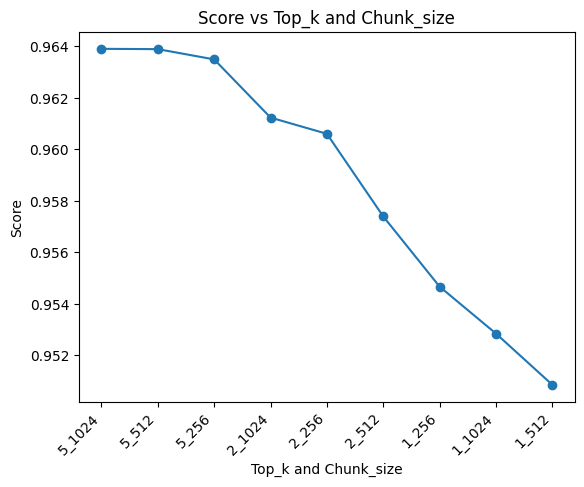

In [ ]:
import matplotlib.pyplot as plt

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a line chart
plt.plot(top_k_chunk_combos, scores, marker='o', linestyle='-')
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()


Score: 0.9638983676470934, Top_k: 5, Chunk_size: 1024
Score: 0.963885900528934, Top_k: 5, Chunk_size: 512
Score: 0.963487726884144, Top_k: 5, Chunk_size: 256
Score: 0.9612301684947645, Top_k: 2, Chunk_size: 1024
Score: 0.960599678303695, Top_k: 2, Chunk_size: 256
Score: 0.9573923091980221, Top_k: 2, Chunk_size: 512
Score: 0.954668662167844, Top_k: 1, Chunk_size: 256
Score: 0.9528468594254222, Top_k: 1, Chunk_size: 1024
Score: 0.9508591283172372, Top_k: 1, Chunk_size: 512


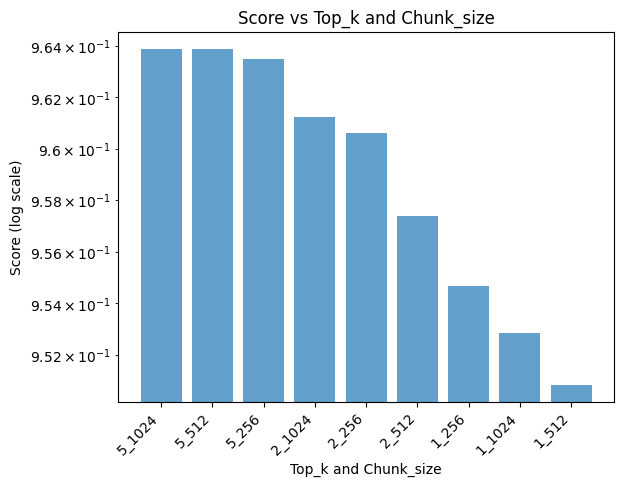

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a bar chart with log scale for the y-axis
plt.bar(top_k_chunk_combos, scores, align='center', alpha=0.7)
plt.yscale('log')  # Set log scale for the y-axis
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score (log scale)')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()
